# Human Resources: Attrition

A large company named XYZ, employs, at any given point of time, around 4000 employees. However, every year, around 15% of its employees leave the company and need to be replaced with the talent pool available in the job market.

**The management believes that this level of attrition (employees leaving, either on their own or because they got fired) is bad for the company, because of the following reasons:**
- The former employees’ projects get delayed, which makes it difficult to meet timelines, resulting in a reputation loss among consumers and partners
- A sizeable department needs to be maintained, for the purposes of recruiting new talent
- Often the new employees need to be trained for the job and/or given time to acclimate themselves to the company


**The company provided 5 tables which included:**
- Employee survey data
    - Included satisfaction ratings from each employee
- Manager survey data
    - Included job involvement and performance rating for each employee
- General data
    - Included attrition information, amount of employee travel time, education level, which department the employee worked in, the employees' level of education, employees' gender and marital status, the monthly income of each employee, and more.
- In time
    - Included the time stamp for each employee for when they started work
- Out time
    - Included the time stamp for each employee for when they ended work

In [149]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.dates as md 
from matplotlib.dates import DateFormatter
%matplotlib inline
import numpy as np
import seaborn as sns
from scipy import stats
import pandas as pd
import statsmodels.api as sm

from statsmodels.stats import diagnostic
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [150]:
e_survey = pd.read_csv("employee_survey_data.csv")
m_survey = pd.read_csv("manager_survey_data.csv")
general = pd.read_csv("general_data.csv")
intime = pd.read_csv("in_time.csv")
outtime = pd.read_csv("out_time.csv")

## Data Cleaning

Data cleaning involved the following: 
- Removing null values
    - Some null values were replaced with the mean values of the columns while others were left in the table due to context of the table
- Removing unnecessary columns
- Merging tables
- Pivoting tables
- Creating new calculated columns

In [151]:
e_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmployeeID               4410 non-null   int64  
 1   EnvironmentSatisfaction  4385 non-null   float64
 2   JobSatisfaction          4390 non-null   float64
 3   WorkLifeBalance          4372 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 137.9 KB


In [152]:
#Need to replace null values in EnvironmentSatisfaction, JobSatisfaction, WorkLifeBalance (replace with mean values)
e_survey['EnvironmentSatisfaction'].fillna((e_survey['EnvironmentSatisfaction'].mean()), inplace=True)
e_survey['JobSatisfaction'].fillna((e_survey['JobSatisfaction'].mean()), inplace=True)
e_survey['WorkLifeBalance'].fillna((e_survey['WorkLifeBalance'].mean()), inplace=True)

In [153]:
#No null values to replace
m_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   EmployeeID         4410 non-null   int64
 1   JobInvolvement     4410 non-null   int64
 2   PerformanceRating  4410 non-null   int64
dtypes: int64(3)
memory usage: 103.5 KB


In [154]:
general.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

In [155]:
#Need to replace null values in NumCompaniesWorked, JobSatisfaction, WorkLifeBalance (replace with mean values)
general['NumCompaniesWorked'].fillna((general['NumCompaniesWorked'].mean()), inplace=True)
general['TotalWorkingYears'].fillna((general['TotalWorkingYears'].mean()), inplace=True)

#Drop columns that have only one variable
general=general.drop(['EmployeeCount', 'StandardHours', 'Over18'], axis=1)

In [156]:
#Merge all employee data
e_survey=e_survey.set_index('EmployeeID')
m_survey=m_survey.set_index('EmployeeID')
general=general.set_index('EmployeeID')

survey=pd.merge(e_survey, m_survey, left_index=True, right_index=True)
dataframe=pd.merge(survey, general, left_index=True, right_index=True)

dataframe.head()

,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Age,Attrition,BusinessTravel,Department,DistanceFromHome,...,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
EmployeeID,,,,,,,,,,,,,,,,,,,,,
1,3.0,4.0,2.0,3,3,51,No,Travel_Rarely,Sales,6,...,Married,131160,1.0,11,0,1.0,6,1,0,0
2,3.0,2.0,4.0,2,4,31,Yes,Travel_Frequently,Research & Development,10,...,Single,41890,0.0,23,1,6.0,3,5,1,4
3,2.0,2.0,1.0,3,3,32,No,Travel_Frequently,Research & Development,17,...,Married,193280,1.0,15,3,5.0,2,5,0,3
4,4.0,4.0,3.0,2,3,38,No,Non-Travel,Research & Development,2,...,Married,83210,3.0,11,3,13.0,5,8,7,5
5,4.0,1.0,3.0,3,3,32,No,Travel_Rarely,Research & Development,10,...,Single,23420,4.0,12,2,9.0,2,6,0,4


In [157]:
intime.head()
#Need to pivot data
#Not replacing NA values since they repesent the employee not coming to work that day

,EmployeeID,1/1/15,1/2/15,1/5/15,1/6/15,1/7/15,1/8/15,1/9/15,1/12/15,1/13/15,...,12/18/15,12/21/15,12/22/15,12/23/15,12/24/15,12/25/15,12/28/15,12/29/15,12/30/15,12/31/15
0,1,NaN,1/2/15 9:43,1/5/15 10:08,1/6/15 9:54,1/7/15 9:34,1/8/15 9:51,1/9/15 10:09,1/12/15 9:42,1/13/15 10:13,...,NaN,12/21/15 9:55,12/22/15 10:04,12/23/15 10:14,12/24/15 10:11,NaN,12/28/15 10:13,12/29/15 10:03,12/30/15 9:54,12/31/15 10:12
1,2,NaN,1/2/15 10:15,1/5/15 10:21,NaN,1/7/15 9:45,1/8/15 10:09,1/9/15 9:43,1/12/15 10:00,1/13/15 10:43,...,12/18/15 10:37,12/21/15 9:49,12/22/15 10:33,12/23/15 10:12,NaN,NaN,12/28/15 9:31,12/29/15 9:55,12/30/15 10:32,12/31/15 9:27
2,3,NaN,1/2/15 10:17,1/5/15 9:50,1/6/15 10:14,1/7/15 9:47,1/8/15 10:03,1/9/15 10:05,1/12/15 10:03,1/13/15 10:21,...,12/18/15 10:15,12/21/15 10:10,12/22/15 9:44,12/23/15 10:15,12/24/15 10:07,NaN,12/28/15 9:42,12/29/15 9:43,12/30/15 9:34,12/31/15 10:28
3,4,NaN,1/2/15 10:05,1/5/15 9:56,1/6/15 10:11,1/7/15 9:37,1/8/15 10:02,1/9/15 10:08,1/12/15 10:13,1/13/15 9:53,...,12/18/15 10:17,12/21/15 9:58,12/22/15 10:04,12/23/15 10:11,12/24/15 9:43,NaN,12/28/15 9:52,12/29/15 9:33,12/30/15 10:18,12/31/15 10:01
4,5,NaN,1/2/15 10:28,1/5/15 9:49,1/6/15 9:45,1/7/15 9:49,1/8/15 10:19,1/9/15 10:00,1/12/15 10:29,1/13/15 9:59,...,12/18/15 9:58,12/21/15 10:03,12/22/15 10:10,12/23/15 10:13,12/24/15 9:44,NaN,12/28/15 10:05,12/29/15 10:30,12/30/15 9:18,12/31/15 9:41


In [158]:
intime=intime.melt(id_vars=['EmployeeID'], var_name='Date', value_name='InTime')
intime.head()

,EmployeeID,Date,InTime
0,1,1/1/15,NaN
1,2,1/1/15,NaN
2,3,1/1/15,NaN
3,4,1/1/15,NaN
4,5,1/1/15,NaN


In [159]:
outtime.head()
#Need to pivot data
#Not replacing NA values since they repesent the employee not coming to work that day

,EmployeeID,1/1/15,1/2/15,1/5/15,1/6/15,1/7/15,1/8/15,1/9/15,1/12/15,1/13/15,...,12/18/15,12/21/15,12/22/15,12/23/15,12/24/15,12/25/15,12/28/15,12/29/15,12/30/15,12/31/15
0,1,NaN,1/2/15 16:56,1/5/15 17:20,1/6/15 17:19,1/7/15 16:34,1/8/15 17:08,1/9/15 17:38,1/12/15 16:58,1/13/15 18:02,...,NaN,12/21/15 17:15,12/22/15 17:27,12/23/15 16:44,12/24/15 17:47,NaN,12/28/15 18:00,12/29/15 17:22,12/30/15 17:40,12/31/15 17:17
1,2,NaN,1/2/15 18:22,1/5/15 17:48,NaN,1/7/15 17:09,1/8/15 17:34,1/9/15 16:52,1/12/15 17:36,1/13/15 18:00,...,12/18/15 18:31,12/21/15 17:34,12/22/15 18:16,12/23/15 17:38,NaN,NaN,12/28/15 17:08,12/29/15 17:54,12/30/15 18:31,12/31/15 17:40
2,3,NaN,1/2/15 16:59,1/5/15 17:06,1/6/15 16:38,1/7/15 16:33,1/8/15 17:24,1/9/15 16:57,1/12/15 17:28,1/13/15 17:21,...,12/18/15 17:02,12/21/15 17:20,12/22/15 16:32,12/23/15 16:59,12/24/15 16:58,NaN,12/28/15 16:43,12/29/15 17:09,12/30/15 17:06,12/31/15 17:15
3,4,NaN,1/2/15 17:25,1/5/15 17:14,1/6/15 17:07,1/7/15 16:32,1/8/15 16:53,1/9/15 17:19,1/12/15 17:13,1/13/15 17:11,...,12/18/15 17:55,12/21/15 16:49,12/22/15 17:24,12/23/15 17:36,12/24/15 16:48,NaN,12/28/15 17:19,12/29/15 16:58,12/30/15 17:40,12/31/15 17:09
4,5,NaN,1/2/15 18:31,1/5/15 17:49,1/6/15 17:26,1/7/15 17:37,1/8/15 17:59,1/9/15 17:44,1/12/15 18:51,1/13/15 18:14,...,12/18/15 17:52,12/21/15 17:43,12/22/15 18:07,12/23/15 18:00,12/24/15 17:59,NaN,12/28/15 17:44,12/29/15 18:47,12/30/15 17:15,12/31/15 17:42


In [160]:
outtime=outtime.melt(id_vars=['EmployeeID'], var_name='Date', value_name='OutTime')
outtime.head()

,EmployeeID,Date,OutTime
0,1,1/1/15,NaN
1,2,1/1/15,NaN
2,3,1/1/15,NaN
3,4,1/1/15,NaN
4,5,1/1/15,NaN


In [161]:
#Need to set columns to be formatted as Date Time
intime['Date'] = pd.to_datetime(intime['Date'])
intime['InTime'] = pd.to_datetime(intime['InTime'])

outtime['Date'] = pd.to_datetime(outtime['Date'])
outtime['OutTime'] = pd.to_datetime(outtime['OutTime'])

In [162]:
#Merge intime and outtime tables (index set to employee id)
times=pd.merge(intime, outtime, left_index=True, right_index=True)

#Rename columns
times=times.rename(columns={"EmployeeID_x": "EmployeeID", "Date_x": "Date"})

#Drop unnecessary columns
times=times.drop(columns=['EmployeeID_y', 'Date_y'])

times.head()

,EmployeeID,Date,InTime,OutTime
0,1,2015-01-01,NaT,NaT
1,2,2015-01-01,NaT,NaT
2,3,2015-01-01,NaT,NaT
3,4,2015-01-01,NaT,NaT
4,5,2015-01-01,NaT,NaT


In [163]:
#Create new column for duration or worked hours for each day
times['Duration'] = (times.OutTime-times.InTime).astype('timedelta64[m]')/60
times=times.set_index('EmployeeID')
duration= times.Duration.groupby(['EmployeeID'], sort=False).mean()
times['Duration'] =times['Duration'].fillna(0)

#Create new columns to document when an employees duration is considered overtime, undertime, or outof the office
times['Overtime'] = np.where(times.Duration > 8, 1, 0)
times['Undertime'] = np.where((times.Duration < 8) & (times.Duration > 0), 1, 0)
times['Out_of_office'] = np.where(times.Duration == 0, 1, 0)

In [164]:
#Grouped by employee to count all the times employees were overtime, undertime, or out of the office
overtimecount=times['Overtime'].groupby(['EmployeeID'], sort=False).value_counts()
undertimecount=times['Undertime'].groupby(['EmployeeID'], sort=False).value_counts()
out_of_officecount=times['Out_of_office'].groupby(['EmployeeID'], sort=False).value_counts()

#Create new table for the counts data, pivot table, and fill in null values with 0
dftimecounts = pd.DataFrame([overtimecount, undertimecount, out_of_officecount]) 
dftimecounts=dftimecounts.transpose()
dftimecounts=dftimecounts.fillna(0)

#Create new table for only when counts occur
dftimecounts1 = dftimecounts.reset_index(level=1, drop=True)
dftimecounts1 = dftimecounts1.loc[~dftimecounts1.index.duplicated(keep='last')]

dftimecounts1.head()

,Overtime,Undertime,Out_of_office
1,0.0,232.0,29.0
2,39.0,194.0,25.0
3,0.0,242.0,19.0
4,0.0,235.0,26.0
5,115.0,128.0,16.0


## Descriptive Analysis

Descriptive analysis was broken down by looking at all time data and employee data separate at first and then them combined. 

The analysis involved the following:
- Histograms
- Boxplots
- Comparative boxplots for Attrition
- Bar Plots

*Descriptions of analysis can be found within the code*

### Time Data

In [165]:
dftimecounts1.Out_of_office.min()

#Predicting that the amount of days the company was closed in the year was about 13 days

13.0

Text(0, 0.5, 'values')

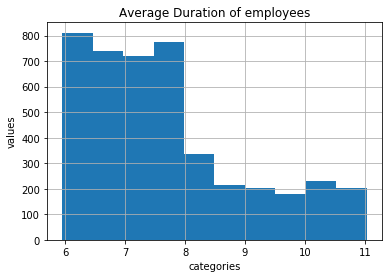

In [166]:
duration.hist()

plt.title('Average Duration of employees')
plt.xlabel('categories')
plt.ylabel('values')
#Most employees work less than an average 8 hours a day

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

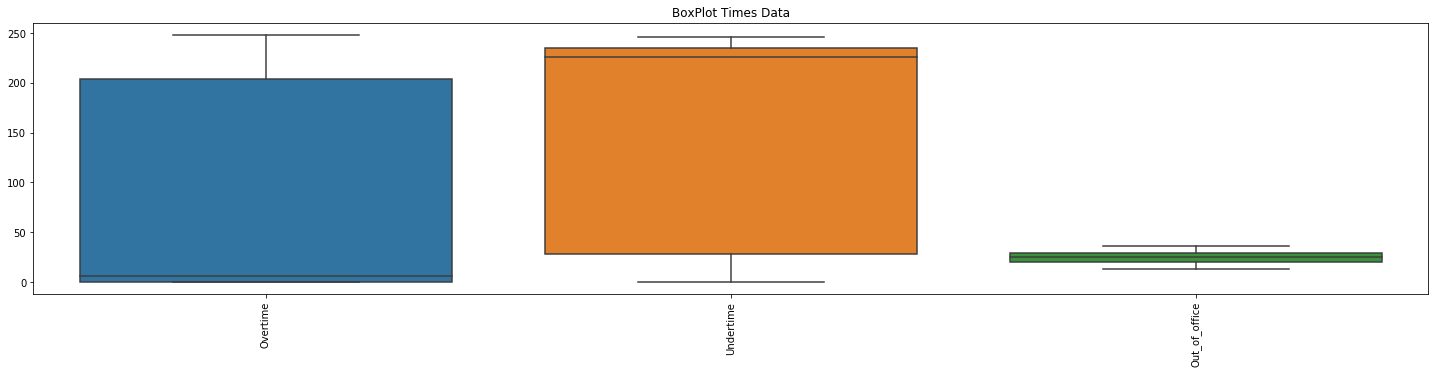

In [167]:
mpl.rcParams['figure.figsize'] = (25,5)
sns.boxplot(data=dftimecounts1)
plt.title("BoxPlot Times Data")
plt.xticks(rotation=90)

#on average emmployees work 75 days of overtime (21%)
#on average employees work 159 days under the standard 8 hours (45%)
#on average employees have 24 days out of the office (days off and close business days included)
    #11 days out of office

Text(0, 0.5, 'Number of employees')

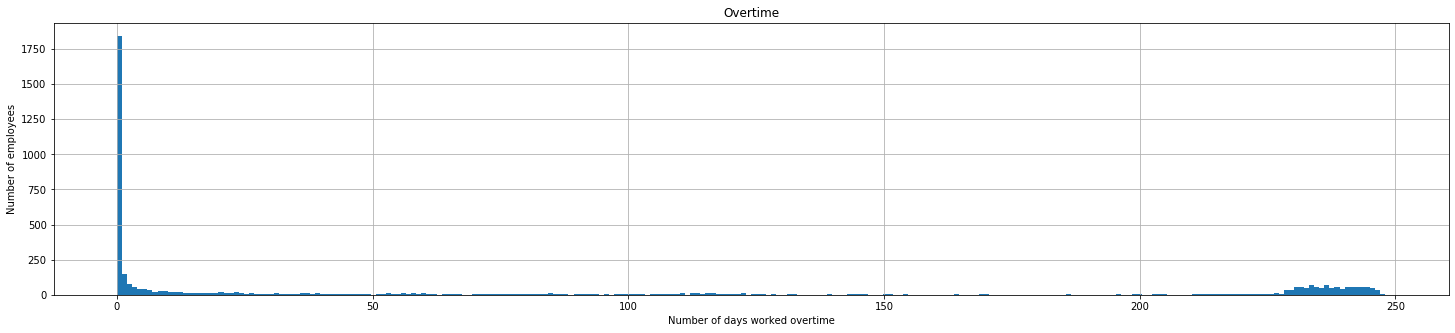

In [168]:
dftimecounts1.Overtime.hist(bins=250)
plt.title('Overtime')
plt.xlabel('Number of days worked overtime')
plt.ylabel('Number of employees')

#Almost all employees worked no overtime within the year

Text(0, 0.5, 'Number of employees')

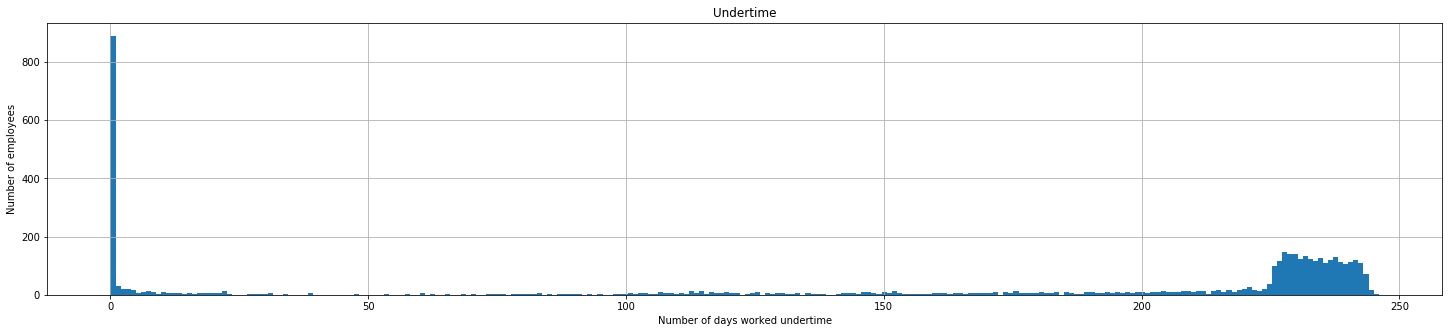

In [169]:
dftimecounts1.Undertime.hist(bins=250)
plt.title('Undertime')
plt.xlabel('Number of days worked undertime')
plt.ylabel('Number of employees')

#A little over 1000 employees worked only 25 days or less under the standard 8 hours
#About 2000 employees between ~225-240 day undertime

#More employees work less than the standard 8 hours
#But about 900 employees work about no days under the standard hours 

Text(0, 0.5, 'Number of employees')

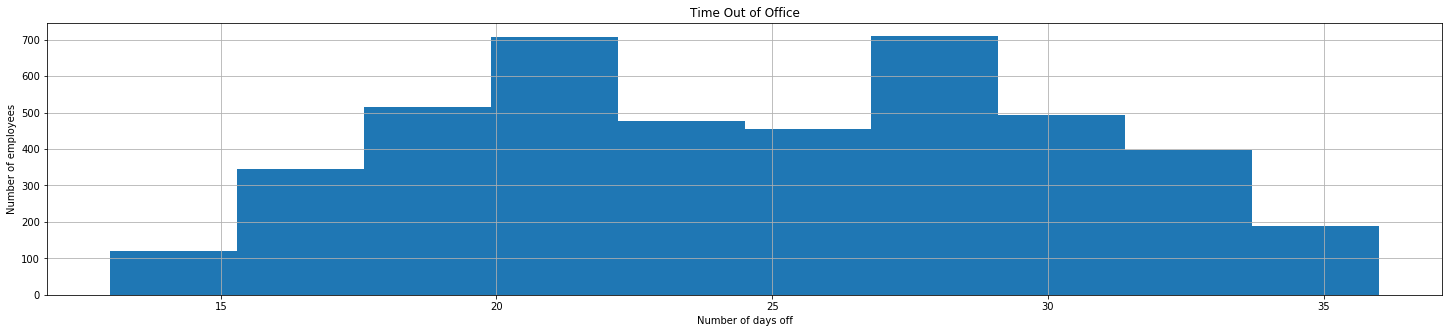

In [170]:
dftimecounts1.Out_of_office.hist()
plt.title('Time Out of Office')
plt.xlabel('Number of days off')
plt.ylabel('Number of employees')

#700 employees take between 20-22 days off (including days the 13 days the building is closed)
    #7-9 without including days closed
#700 employees take between 26-28 days off (including days the 13 days the building is closed)
    #13-15 without including days closed
#About 100 employees don't (or rarely) take days off 

### Employee Data

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 <a list of 18 Text xticklabel objects>)

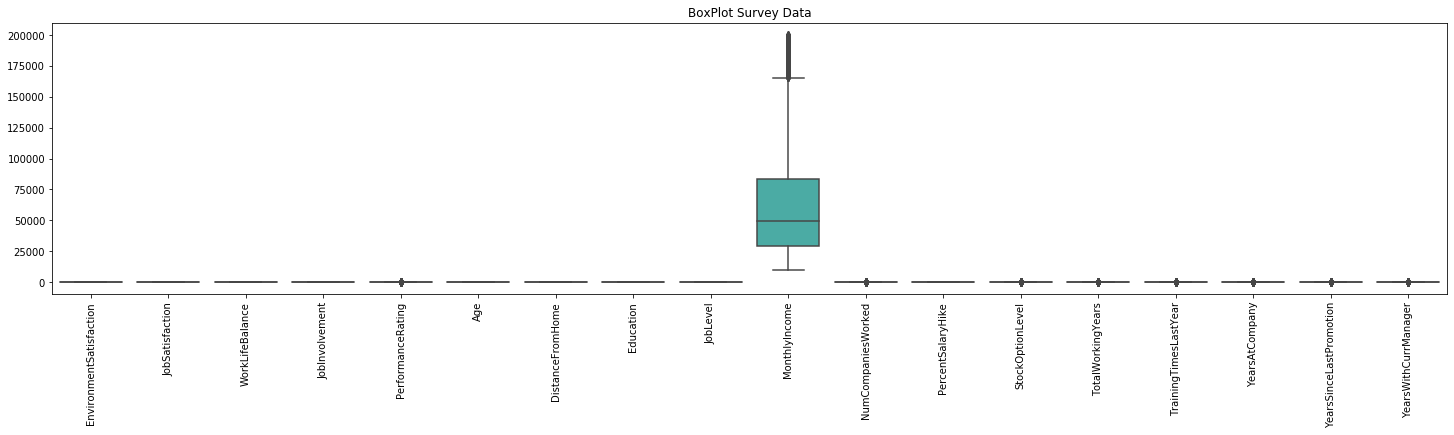

In [171]:
mpl.rcParams['figure.figsize'] = (25,5)
sns.boxplot(data=dataframe)
plt.title("BoxPlot Survey Data")
plt.xticks(rotation=90)

#Visually hard to see due to large values within MonthlyIncome column

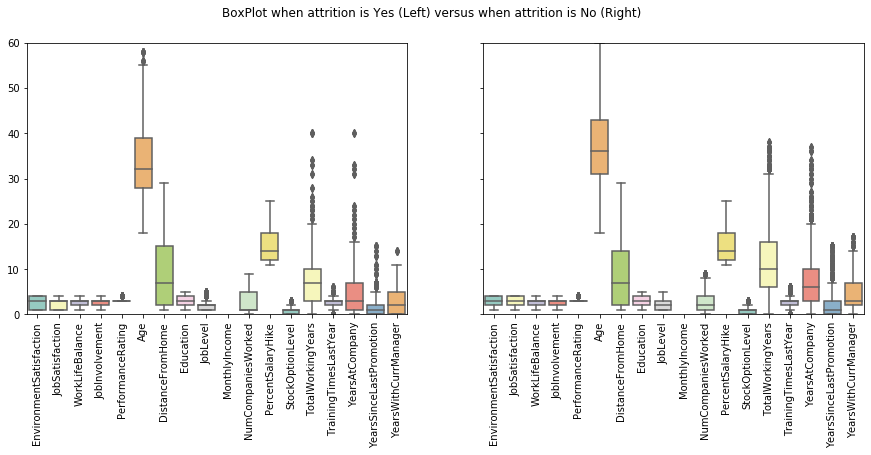

In [172]:
#Comparing box plots when attrition is Yes vs. No
dataframe_boxplots = dataframe[dataframe['Attrition']=='Yes']
mpl.rcParams['figure.figsize'] = (15,5)
f, axes = plt.subplots(1, 2, sharey=True)

f.suptitle("BoxPlot when attrition is Yes (Left) versus when attrition is No (Right)")
sns.boxplot(data=dataframe_boxplots, orient='v', palette='Set3', ax=axes[0])

dataframe_boxplots = dataframe[dataframe['Attrition']=='No']
sns.boxplot(data=dataframe_boxplots, orient='v', palette='Set3', ax=axes[1])

for ax in f.axes:
    mpl.pyplot.sca(ax)
    plt.ylim(0,60)
    plt.xticks(rotation=90)
    
plt.show()

#Monthly Income is not visible due to higher values (comparative boxplot further below)

#Insights:
#Variables that stand out are age, job level, total work years, years, at company, years since last promotion, years with current manager, environment staisifaction, job staisfaction

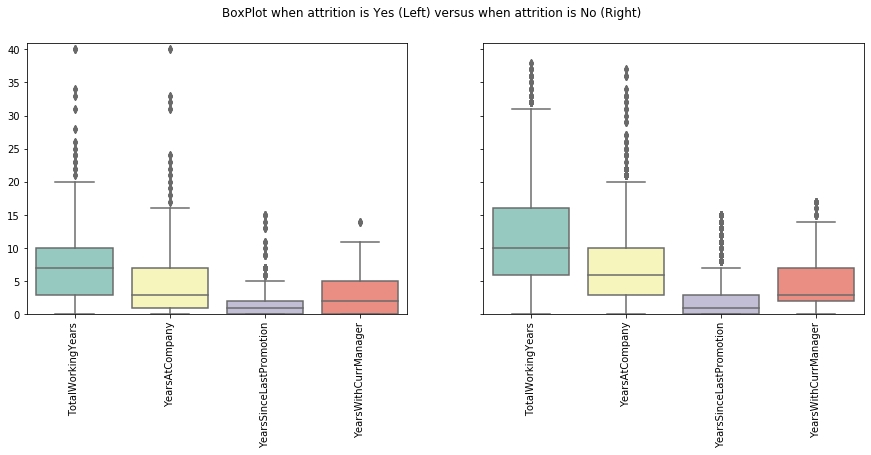

In [173]:
#Variables that stand out are age, job level, total work years, years, at company, years since last promotion, years with current manager, environment staisifaction, job staisfaction
filt1=['TotalWorkingYears', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
filt2=['Age']
filt3=['JobLevel', 'EnvironmentSatisfaction', 'JobSatisfaction']
filt4=['MonthlyIncome']

#Comparing box plots when attrition is Yes vs. No for values showing variation
dataframe_boxplots = dataframe[dataframe['Attrition']=='Yes']
mpl.rcParams['figure.figsize'] = (15,5)
f, axes = plt.subplots(1, 2, sharey=True)

f.suptitle("BoxPlot when attrition is Yes (Left) versus when attrition is No (Right)")
sns.boxplot(data=dataframe_boxplots[filt1], orient='v', palette='Set3', ax=axes[0])

dataframe_boxplots = dataframe[dataframe['Attrition']=='No']
sns.boxplot(data=dataframe_boxplots[filt1], orient='v', palette='Set3', ax=axes[1])

for ax in f.axes:
    mpl.pyplot.sca(ax)
    plt.ylim(0,41)
    plt.xticks(rotation=90)
    
plt.show()

#Those that stay are working more years
#Those who leave were not at company for very long
#Years since last promotion does not seem to have as great of an impact on attrition
#Year with current manager:Median and mean are slightly less when attrition is less (Yes: Mean=2.8 and Median=2; No: Mean=4.3 and Median=3); Those who are with manager for longer tend to stay longer

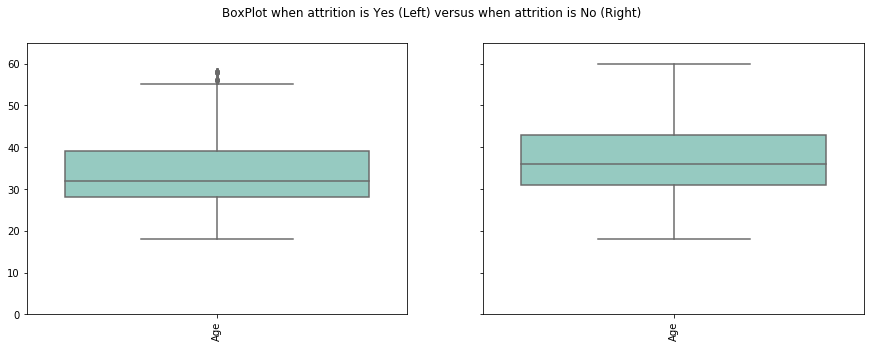

In [174]:
dataframe_boxplots = dataframe[dataframe['Attrition']=='Yes']
mpl.rcParams['figure.figsize'] = (15,5)
f, axes = plt.subplots(1, 2, sharey=True)

f.suptitle("BoxPlot when attrition is Yes (Left) versus when attrition is No (Right)")
sns.boxplot(data=dataframe_boxplots[filt2], orient='v', palette='Set3', ax=axes[0])

dataframe_boxplots = dataframe[dataframe['Attrition']=='No']
sns.boxplot(data=dataframe_boxplots[filt2], orient='v', palette='Set3', ax=axes[1])

for ax in f.axes:
    mpl.pyplot.sca(ax)
    plt.ylim(0,65)
    plt.xticks(rotation=90)
    
plt.show()

#Younger employees end up leaving the company

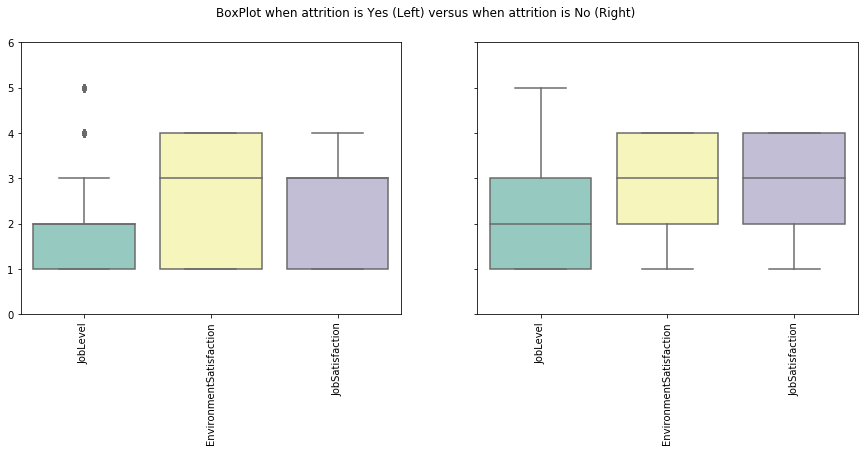

In [175]:
dataframe_boxplots = dataframe[dataframe['Attrition']=='Yes']
mpl.rcParams['figure.figsize'] = (15,5)
f, axes = plt.subplots(1, 2, sharey=True)

f.suptitle("BoxPlot when attrition is Yes (Left) versus when attrition is No (Right)")
sns.boxplot(data=dataframe_boxplots[filt3], orient='v', palette='Set3', ax=axes[0])

dataframe_boxplots = dataframe[dataframe['Attrition']=='No']
sns.boxplot(data=dataframe_boxplots[filt3], orient='v', palette='Set3', ax=axes[1])

for ax in f.axes:
    mpl.pyplot.sca(ax)
    plt.ylim(0,6)
    plt.xticks(rotation=90)
    
plt.show()

#Lower job levels are leaving
#Environment satisifaction is slighty lower of those who leave. Leading me to believe they are leaving because they are dissatisfied with the environment
#Job satisfaction is varied between 1-3 with median of 3. Leading me to believe that some may have been dissatisfied with their job

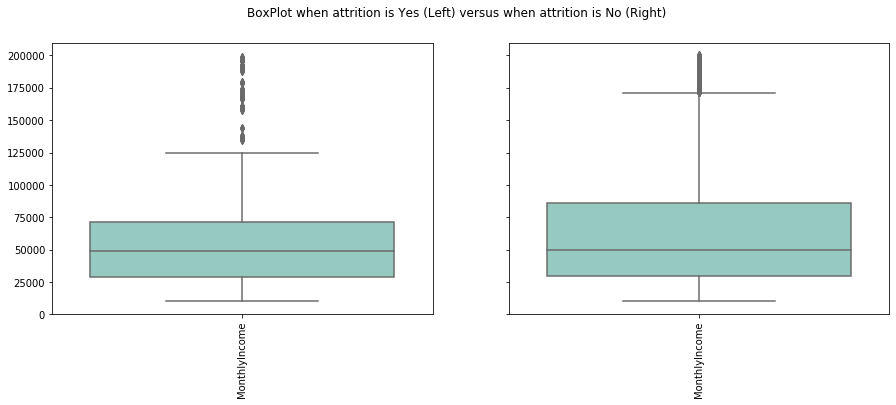

In [176]:
dataframe_boxplots = dataframe[dataframe['Attrition']=='Yes']
mpl.rcParams['figure.figsize'] = (15,5)
f, axes = plt.subplots(1, 2, sharey=True)

f.suptitle("BoxPlot when attrition is Yes (Left) versus when attrition is No (Right)")
sns.boxplot(data=dataframe_boxplots[filt4], orient='v', palette='Set3', ax=axes[0])

dataframe_boxplots = dataframe[dataframe['Attrition']=='No']
sns.boxplot(data=dataframe_boxplots[filt4], orient='v', palette='Set3', ax=axes[1])

for ax in f.axes:
    mpl.pyplot.sca(ax)
    plt.ylim(0,210000)
    plt.xticks(rotation=90)
    
plt.show()

#Although the median is about the same the IQR for attrition=yes is significantly smaller for the Monthly Income

Text(0, 0.5, 'Number of employees')

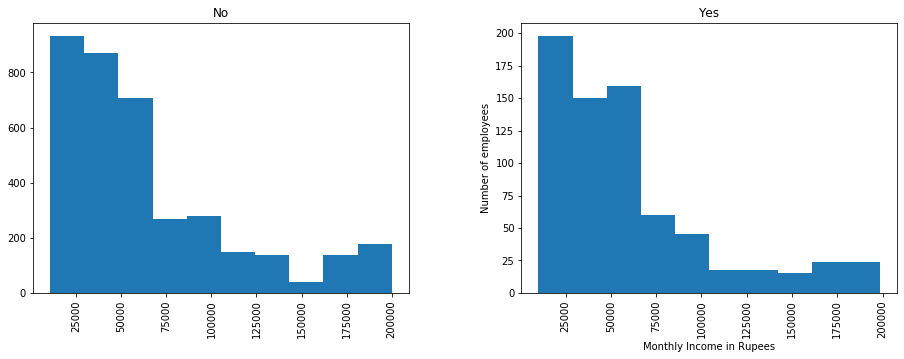

In [177]:
dataframe.MonthlyIncome.hist(by=dataframe.Attrition)
plt.xlabel('Monthly Income in Rupees')
plt.ylabel('Number of employees')

#slight increase in monthly income when attrition=no

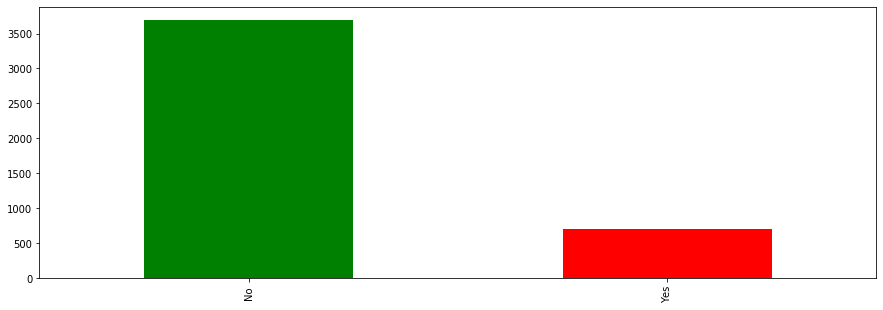

In [178]:
dataframe['Attrition'].value_counts().plot(kind='bar', color=['green', 'red'])

#Attrition rate was 14% last year

In [179]:
grouped = dataframe.groupby(['EnvironmentSatisfaction','Attrition'])
size = grouped.size()
size

#Attrition=Yes
#25% at 1
#18% at 2
#26% at 3
#25% at 4

#Attrition=No
#17% at 1
#19% at 2
#30% at 3
#31% at 4

#Greater percentage of employee voted in the 3-4 range on environment satisfaction when attrition=no

EnvironmentSatisfaction  Attrition
1.000000                 No            632
                         Yes           213
2.000000                 No            728
                         Yes           128
2.723603                 No             20
                         Yes             5
3.000000                 No           1164
                         Yes           186
4.000000                 No           1155
                         Yes           179
dtype: int64

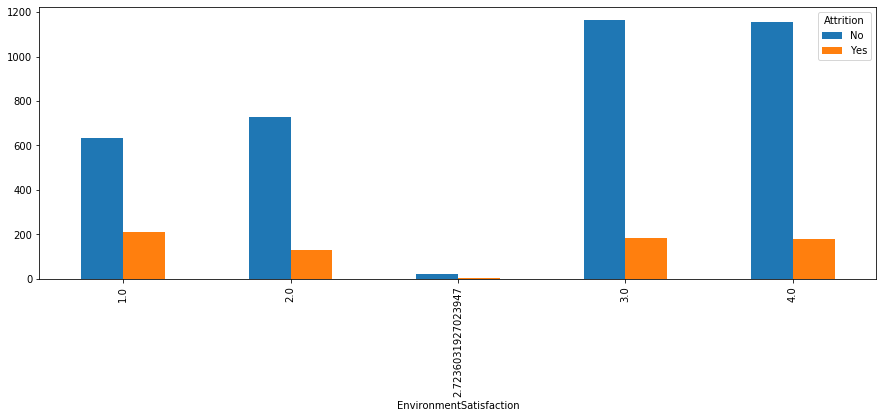

In [180]:
size.unstack().plot.bar()

In [181]:
grouped = dataframe.groupby(['JobSatisfaction','Attrition'])
size = grouped.size()
size

#Attrition=Yes
#27% at 1
#19% at 2
#30% at 3
#21% at 4

#Attrition=No
#17% at 1
#18% at 2
#29% at 3
#32% at 4

#Greater percentage of employee voted in the 3-4 range on job satisfaction when attrition=no

JobSatisfaction  Attrition
1.000000         No            663
                 Yes           197
2.000000         No            702
                 Yes           138
2.728246         No             19
                 Yes             1
3.000000         No           1104
                 Yes           219
4.000000         No           1211
                 Yes           156
dtype: int64

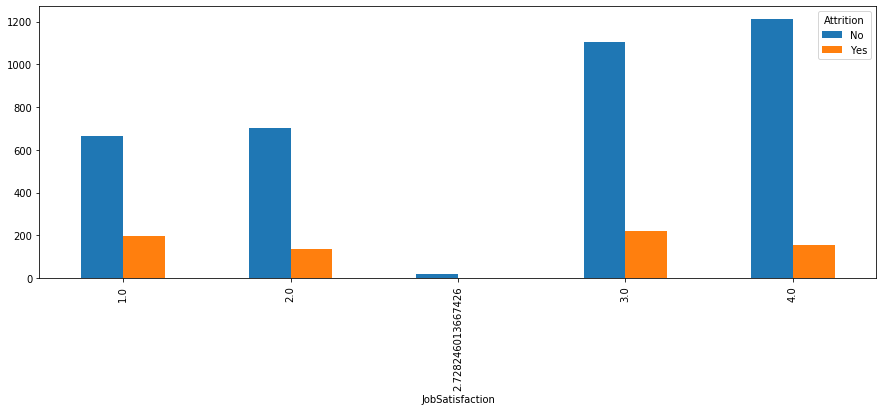

In [182]:
size.unstack().plot.bar()

In [183]:
grouped = dataframe.groupby(['BusinessTravel','Attrition'])
size = grouped.size()
size

#Attrition=Yes
#5% Non-Travel
#29% Travel_Frequently
#46% Travel Rarely

#Attrition=No
#11% Non-Travel
#16% Travel_Frequently
#71% Travel Rarely

# Greater percent travel frequently when attrition is yes

BusinessTravel     Attrition
Non-Travel         No            414
                   Yes            36
Travel_Frequently  No            624
                   Yes           207
Travel_Rarely      No           2661
                   Yes           468
dtype: int64

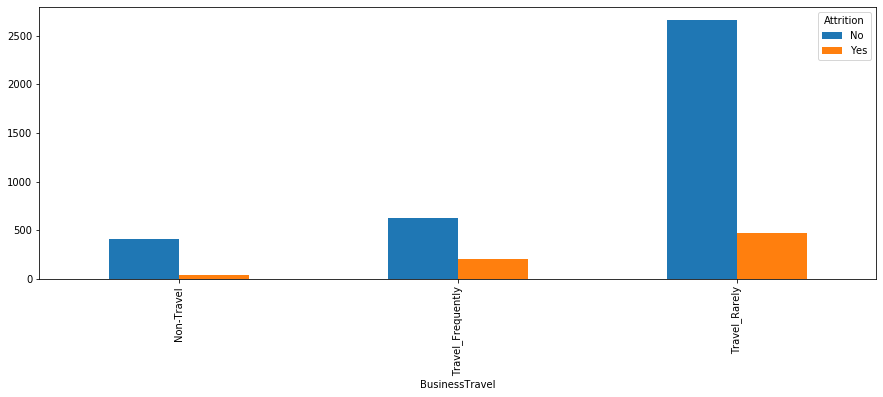

In [184]:
size.unstack().plot.bar()

In [185]:
grouped = dataframe.groupby(['Attrition', 'BusinessTravel','Department'])
size = grouped.size()
size

Attrition  BusinessTravel     Department            
No         Non-Travel         Human Resources              9
                              Research & Development     297
                              Sales                      108
           Travel_Frequently  Human Resources             18
                              Research & Development     387
                              Sales                      219
           Travel_Rarely      Human Resources            105
                              Research & Development    1746
                              Sales                      810
Yes        Non-Travel         Research & Development      33
                              Sales                        3
           Travel_Frequently  Human Resources              6
                              Research & Development     132
                              Sales                       69
           Travel_Rarely      Human Resources             51
                              Re

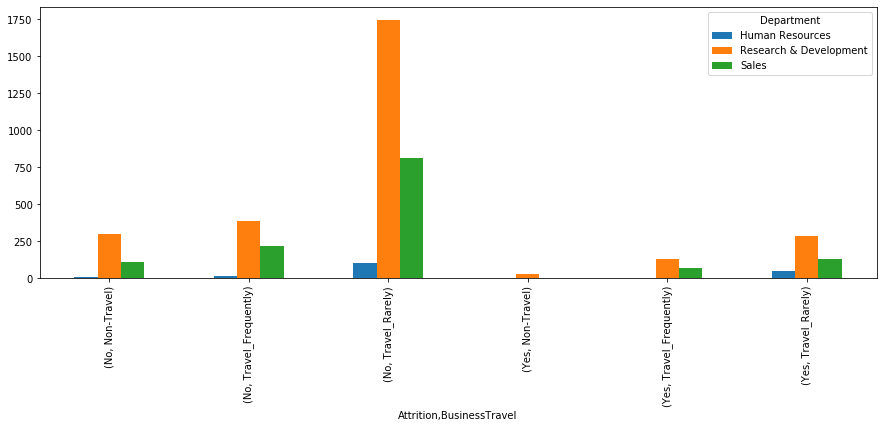

In [186]:
size.unstack().plot.bar()

#Attrition=Yes
#No sales travels frequently
#Most travel from the research and development department

In [187]:
grouped = dataframe.groupby(['JobRole','Attrition'])
size = grouped.size()
size

#Attrition=Yes
# 8% Healthcare Representative
# 2% Human Resources 
# 17% Laboratory Technician  
# 5% Manager    
# 6% Manufacturing Director 
# 8% Research Director 
# 22% Research Scientist 
# 23% Sales Executive     
# 5% Sales Representative 

#Attrition=No
# 9% Healthcare Representative
# 3% Human Resources 
# 17% Laboratory Technician  
# 7% Manager    
# 10% Manufacturing Director 
# 4% Research Director 
# 17% Research Scientist 
# 21% Sales Executive     
# 5% Sales Representative 

#Not a signifiacant difference based on job role (Slight increase in % of research directors where attrition is yes)

JobRole                    Attrition
Healthcare Representative  No           336
                           Yes           57
Human Resources            No           135
                           Yes           21
Laboratory Technician      No           651
                           Yes          126
Manager                    No           264
                           Yes           42
Manufacturing Director     No           387
                           Yes           48
Research Director          No           183
                           Yes           57
Research Scientist         No           717
                           Yes          159
Sales Executive            No           813
                           Yes          165
Sales Representative       No           213
                           Yes           36
dtype: int64

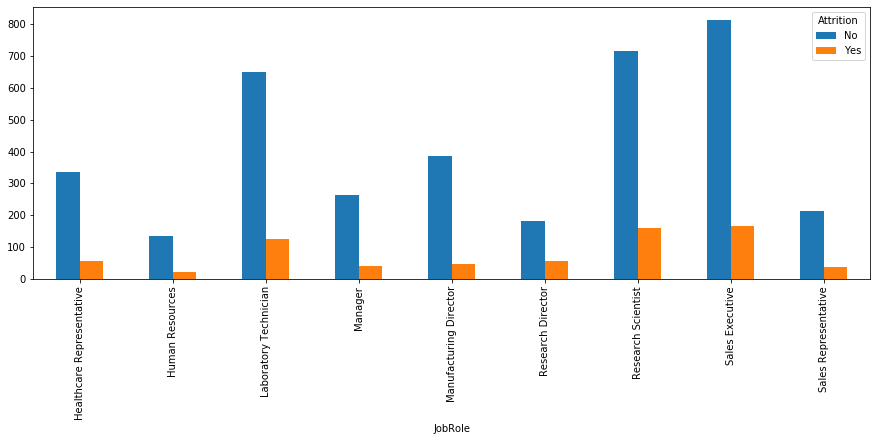

In [188]:
size.unstack().plot.bar()

In [189]:
grouped = dataframe.groupby(['MaritalStatus','Attrition'])
size = grouped.size()
size

#Attrition=Yes
# 13% Divorced
# 35% Married
# 50% Single

#Attrition=No
# 23% Divorced
# 47% Married
# 28% Single

#More married people stay at company than single people; 50% of employees who leave are single!

MaritalStatus  Attrition
Divorced       No            882
               Yes            99
Married        No           1767
               Yes           252
Single         No           1050
               Yes           360
dtype: int64

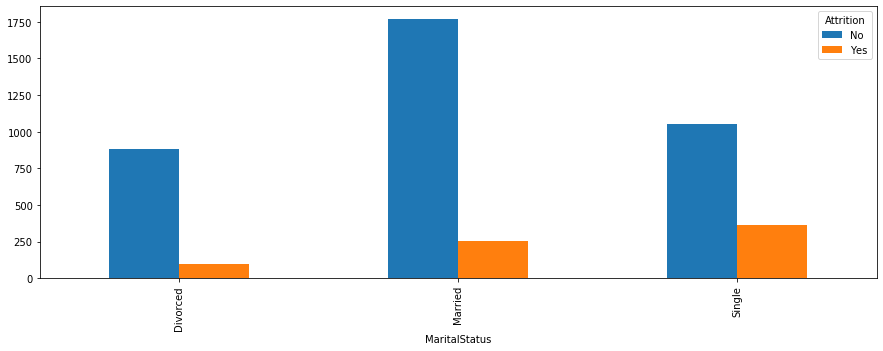

In [190]:
size.unstack().plot.bar()

### Time and Employee Data 

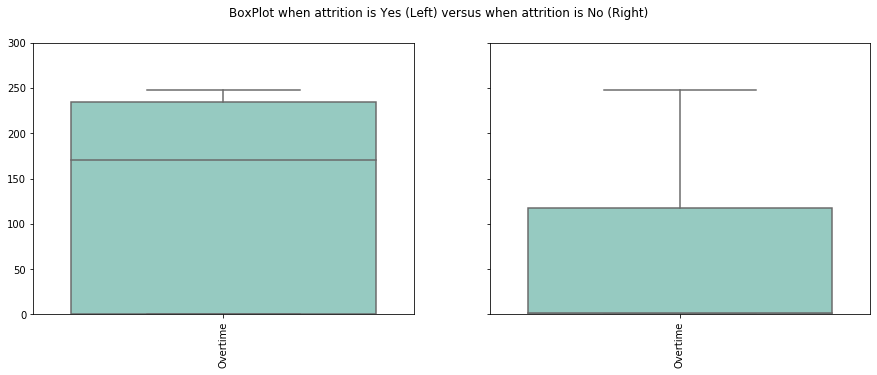

In [191]:
#Combine time counts table with employee data
df=pd.merge(dataframe, dftimecounts1, left_index=True, right_index=True)

filt2=['Overtime']
filt3=['Undertime']

dataframe_boxplots = df[df['Attrition']=='Yes']
mpl.rcParams['figure.figsize'] = (15,5)
f, axes = plt.subplots(1, 2, sharey=True)

f.suptitle("BoxPlot when attrition is Yes (Left) versus when attrition is No (Right)")
sns.boxplot(data=dataframe_boxplots[filt2], orient='v', palette='Set3', ax=axes[0])

dataframe_boxplots = df[df['Attrition']=='No']
sns.boxplot(data=dataframe_boxplots[filt2], orient='v', palette='Set3', ax=axes[1])

for ax in f.axes:
    mpl.pyplot.sca(ax)
    plt.ylim(0,300)
    plt.xticks(rotation=90)
    
plt.show()

#More employees working overtime end up leaving

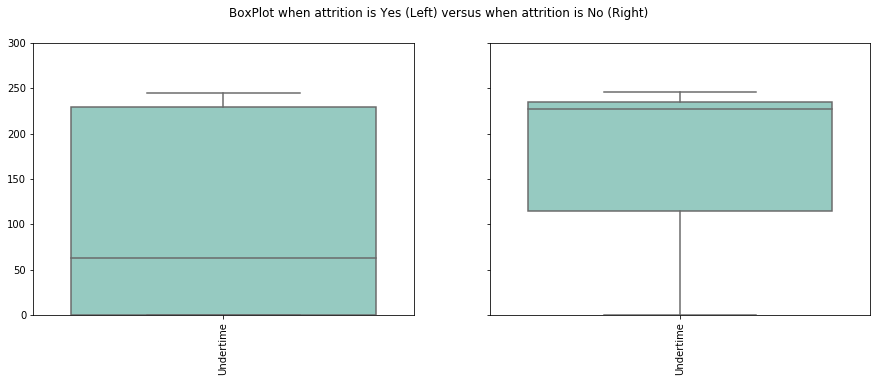

In [192]:
dataframe_boxplots = df[df['Attrition']=='Yes']
mpl.rcParams['figure.figsize'] = (15,5)
f, axes = plt.subplots(1, 2, sharey=True)

f.suptitle("BoxPlot when attrition is Yes (Left) versus when attrition is No (Right)")
sns.boxplot(data=dataframe_boxplots[filt3], orient='v', palette='Set3', ax=axes[0])

dataframe_boxplots = df[df['Attrition']=='No']
sns.boxplot(data=dataframe_boxplots[filt3], orient='v', palette='Set3', ax=axes[1])

for ax in f.axes:
    mpl.pyplot.sca(ax)
    plt.ylim(0,300)
    plt.xticks(rotation=90)
    
plt.show()

#Those that stay are working less hours

## Inferential Statistics

Linear regression model was created to determine which combination of variable/s would determine attrition.

Variables were determined insignificant by using values with little to no correlation to the variable of Attrition and the p-values of each variable.

In [193]:
#Creating dummy variables for categorical data
dataframe['Attrition_Yes']=dataframe.Attrition.map({'No':0, 'Yes':1})
dataframe['BusinessTravel_Frequent']=dataframe.BusinessTravel.map({'Non-Travel':0, 'Travel_Rarely':0, 'Travel_Frequently':1})
dataframe['BusinessTravel_Nontravel']=dataframe.BusinessTravel.map({'Non-Travel':1, 'Travel_Rarely':0, 'Travel_Frequently':0})
dataframe['BusinessTravel_Rarely']=dataframe.BusinessTravel.map({'Non-Travel':0, 'Travel_Rarely':1, 'Travel_Frequently':0})
dataframe['MaritalStatus_Married']=dataframe.MaritalStatus.map({'Divorced':0, 'Married':1, 'Single':0})
dataframe['MaritalStatus_Single']=dataframe.MaritalStatus.map({'Divorced':0, 'Married':0, 'Single':1})
dataframe['MaritalStatus_Divorced']=dataframe.MaritalStatus.map({'Divorced':1, 'Married':0, 'Single':0})

In [194]:
#Dropped columns that corresponded to dummy variables
dataframe=dataframe.drop(['Attrition', 'Gender', 'BusinessTravel', 'Department', 'MaritalStatus', 'EducationField', 'JobRole'], axis=1)
#Combined employee data and time counts data
df=pd.merge(dataframe, dftimecounts1, left_index=True, right_index=True)
df = df.astype(float)

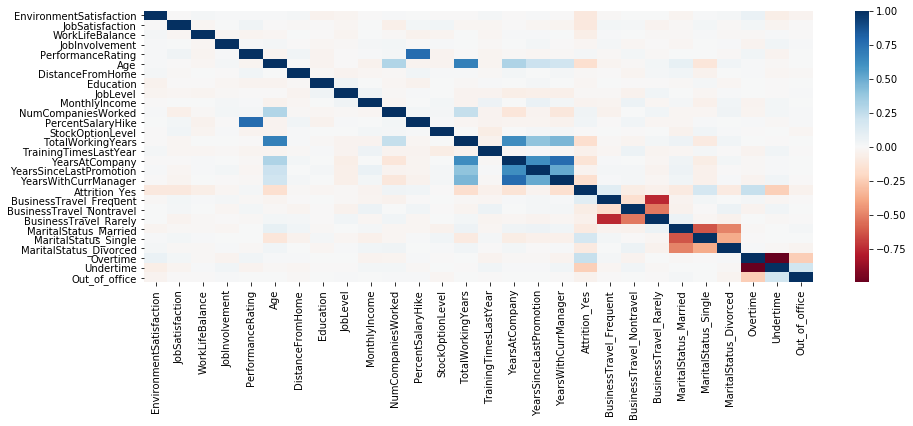

In [195]:
# calculate the correlation matrix
corr =df.corr()

# plot the correlation heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')

In [196]:
# define after the drop
df_after = df.drop(['Attrition_Yes'], axis = 1)

X1 = sm.tools.add_constant(df)
X2 = sm.tools.add_constant(df_after)

# create the series
series_after = pd.Series([variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])], index=X2.columns)

# display the series
print('DATA AFTER')
print('-'*100)
display(series_after)

/Users/kaitlinrouse/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/kaitlinrouse/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


DATA AFTER
----------------------------------------------------------------------------------------------------


const                          0.000000
EnvironmentSatisfaction        1.012089
JobSatisfaction                1.013033
WorkLifeBalance                1.009753
JobInvolvement                 1.007464
PerformanceRating              2.524365
Age                            2.013341
DistanceFromHome               1.010755
Education                      1.010971
JobLevel                       1.018407
MonthlyIncome                  1.026095
NumCompaniesWorked             1.248594
PercentSalaryHike              2.529772
StockOptionLevel               1.019685
TotalWorkingYears              3.085986
TrainingTimesLastYear          1.021960
YearsAtCompany                 3.965391
YearsSinceLastPromotion        1.654629
YearsWithCurrManager           2.501985
BusinessTravel_Frequent             inf
BusinessTravel_Nontravel            inf
BusinessTravel_Rarely               inf
MaritalStatus_Married               inf
MaritalStatus_Single                inf
MaritalStatus_Divorced              inf


In [197]:
# define our input variable (X) & output variable
df_after = df.drop(['DistanceFromHome','StockOptionLevel', 'JobInvolvement', 'JobLevel', 'BusinessTravel_Nontravel', 'MaritalStatus_Married', 'MaritalStatus_Divorced', 'PerformanceRating', 'MonthlyIncome', 'PercentSalaryHike', 'BusinessTravel_Rarely', 'Education', 'YearsAtCompany', 'Undertime', 'Out_of_office'], axis = 1)

X = df_after.drop('Attrition_Yes', axis = 1)
Y = df_after[['Attrition_Yes']]

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

# Linear Regression model object
regression_model = LinearRegression()

# pass through the X_train & y_train data set
regression_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [198]:
# Multiple predictions
y_predict = regression_model.predict(X_test)

# Show the first 5 predictions
y_predict[:5]

array([[ 0.07857457],
       [ 0.48631521],
       [ 0.09110235],
       [ 0.22260187],
       [-0.0200578 ]])

In [199]:
# define intput
X2 = sm.add_constant(X)

# create OLS model
model = sm.OLS(Y, X2)

#fit the data
est = model.fit()

In [200]:
import math

#Mean squared error
model_mse = mean_squared_error(y_test, y_predict)

#Mean absolute error
model_mae = mean_absolute_error(y_test, y_predict)

#Root mean squared error
model_rmse =  math.sqrt(model_mse)

print("MSE {:.3}".format(model_mse))
print("MAE {:.3}".format(model_mae))
print("RMSE {:.3}".format(model_rmse))

MSE 0.123
MAE 0.255
RMSE 0.35


In [201]:
est.pvalues

const                      3.784945e-50
EnvironmentSatisfaction    7.661426e-18
JobSatisfaction            2.087994e-17
WorkLifeBalance            2.232395e-06
Age                        1.940432e-07
NumCompaniesWorked         3.604505e-10
TotalWorkingYears          3.527378e-06
TrainingTimesLastYear      1.736529e-04
YearsSinceLastPromotion    2.235717e-10
YearsWithCurrManager       2.635188e-12
BusinessTravel_Frequent    7.914639e-15
MaritalStatus_Single       8.687469e-31
Overtime                   2.282043e-66
dtype: float64

In [202]:
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:          Attrition_Yes   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     80.20
Date:                Thu, 21 May 2020   Prob (F-statistic):          8.47e-179
Time:                        20:28:30   Log-Likelihood:                -1409.4
No. Observations:                4410   AIC:                             2845.
Df Residuals:                    4397   BIC:                             2928.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

## Insights from Analysis

1. More employees working overtime end up leaving
    - Attrition=Yes; Mean of count of overtime = 0.494086
    - Attrition=No; Mean of count of overtime = 0.250761
2. Employees who stay are working more years at company
    - Those who are with manager for longer tend to stay
3. Lower job levels are leaving 
    - Typically younger and single employees
4. Less employees vote in 3-4 range on job and environment satisfaction when they leave
    - Environment satisfaction is slightly higher for those who stay; employees are leaving because they are dissatisfied with the environment
    - Job satisfaction is varied between 1-3 with median of 3; employees are dissatisfied with their job
5. Greater percent of employees travel frequently when attrition is yes
    - 16% of employees who stayed and 29% of employees who leave say they traveled frequently. 
    - 18% of total employees travel
    - Most travel from the research and development department